# Sensitivity Analysis

This notebook performs comprehensive sensitivity analysis on key parameters of the AI-enhanced 60/40 portfolio strategy.

## Objectives:
1. Test different lookback periods
2. Vary maximum Bitcoin allocation
3. Adjust model hyperparameters
4. Analyze robustness of results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from itertools import product
import warnings
warnings.filterwarnings('ignore')
from data_acquisition import DataAcquisition
from feature_engineering import FeatureEngineer
from ml_model import PortfolioMLModel
from backtester import PortfolioBacktester
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Setup and Data Loading

In [2]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)
data_acq = DataAcquisition(config)
prices, returns, indicators = data_acq.get_full_dataset()
print(f"Data loaded: {len(prices)} periods from {prices.index[0]} to {prices.index[-1]}")

Fetching asset prices...
Fetched prices for 4 assets from 2017-01-01 00:00:00 to 2024-12-30 00:00:00
Fetching VIX data...
Fetching yield spread data...
Fetching interest rate data...

Indicators summary:
             VIX  Yield_Spread  Interest_Rate
count  2922.0000     2922.0000      2922.0000
mean     18.6570        0.4484         2.1637
std       7.6876        0.9770         1.9075
min       9.1400       -1.7040         0.0400
25%      13.2225       -0.2868         0.2700
50%      16.8800        0.5650         1.6900
75%      21.8800        1.2457         4.3300
max      82.6900        2.3080         5.3300
Data loaded: 96 periods from 2017-01-31 00:00:00 to 2024-12-31 00:00:00


## 2. Lookback Period Sensitivity

In [3]:
# Test different lookback periods
lookback_periods = config['sensitivity']['lookback_periods']

print(f"Testing lookback periods: {lookback_periods}")
print(f"This will take a few minutes...\n")

lookback_results = {}

for lookback in lookback_periods:
    print(f"Testing lookback period: {lookback} months")
    
    # Create features with different rolling windows based on lookback
    feature_eng = FeatureEngineer(config)
    features_raw = feature_eng.engineer_all_features(indicators)
    features = feature_eng.prepare_features_for_training(features_raw)
    
    # Train model
    ml_model = PortfolioMLModel(config)
    targets = ml_model.create_target_variables(returns, lookback=1)
    
    # Use lookback for train size
    min_train_size = lookback + 12  # Ensure enough data
    test_size = max(0.2, min_train_size / len(features))
    
    X_train, X_test, y_train, y_test = ml_model.prepare_train_test_data(
        features, targets, test_size=test_size
    )
    
    ml_model.train_all_models(X_train, y_train)
    
    # Generate allocations
    predicted_returns = ml_model.predict_returns(features)
    allocations = ml_model.calculate_optimal_allocations(predicted_returns)
    
    # Backtest
    backtester = PortfolioBacktester(config)
    results = backtester.backtest_strategy(allocations, returns, prices)
    metrics = backtester.calculate_all_metrics(results)
    
    lookback_results[f'{lookback}M'] = metrics
    
    print(f"  Sharpe Ratio: {metrics['Sharpe Ratio']:.4f}")
    print()

print("Lookback period analysis complete!")


Testing lookback periods: [6, 12, 18, 24]
This will take a few minutes...

Testing lookback period: 6 months

Training Models for All Assets
Training model for BTC-USD...
  Training MSE: 0.000621
  Training R²: 0.4402
Training model for GLD...
  Training MSE: 0.000026
  Training R²: 0.5501
Training model for SPY...
  Training MSE: 0.000033
  Training R²: 0.5703
Training model for TLT...
  Training MSE: 0.000017
  Training R²: 0.6720

Trained 4 models successfully!
  Sharpe Ratio: -0.3918

Testing lookback period: 12 months

Training Models for All Assets
Training model for BTC-USD...
  Training MSE: 0.000654
  Training R²: 0.4566
Training model for GLD...
  Training MSE: 0.000028
  Training R²: 0.5447
Training model for SPY...
  Training MSE: 0.000037
  Training R²: 0.4972
Training model for TLT...
  Training MSE: 0.000018
  Training R²: 0.6248

Trained 4 models successfully!
  Sharpe Ratio: -0.2299

Testing lookback period: 18 months

Training Models for All Assets
Training model for 

In [4]:
lookback_df = pd.DataFrame(lookback_results).T
print("Lookback Period Sensitivity Results:")
display(lookback_df[['Sharpe Ratio', 'Sortino Ratio', 'CAGR', 'Max Drawdown', 'Volatility']])

Lookback Period Sensitivity Results:


,Sharpe Ratio,Sortino Ratio,CAGR,Max Drawdown,Volatility
6M,-0.3918,-0.5714,-0.0057,0.0896,0.0507
12M,-0.2299,-0.3699,0.0012,0.0842,0.0518
18M,-0.2432,-0.3680,0.0017,0.0930,0.0521
24M,-0.3242,-0.4537,0.0015,0.1096,0.0529


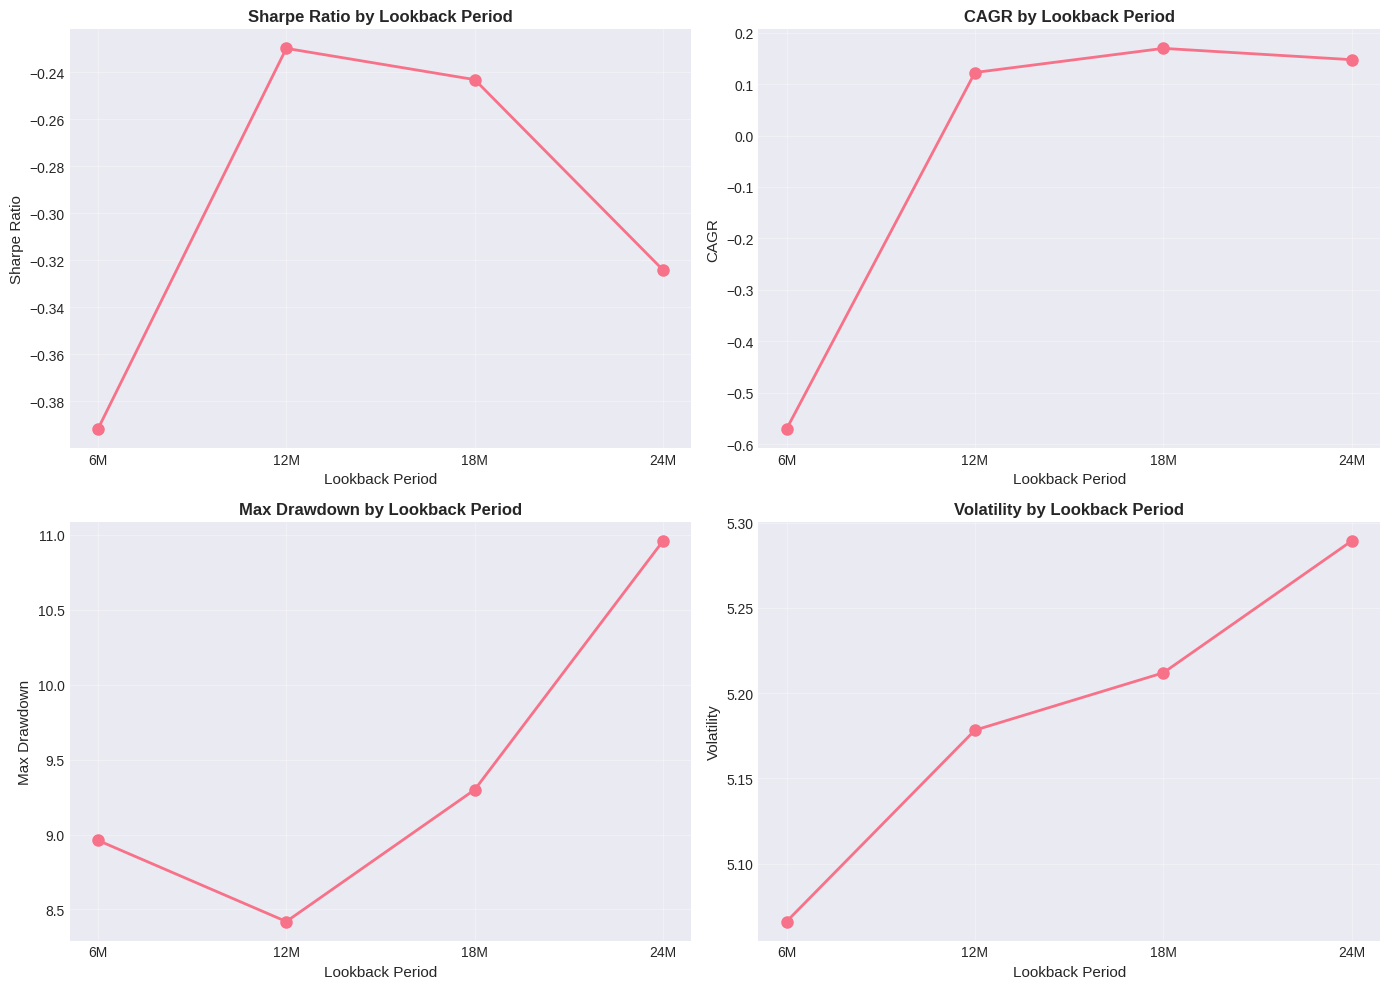

In [5]:
# Visualize lookback period impact
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['Sharpe Ratio', 'CAGR', 'Max Drawdown', 'Volatility']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    values = lookback_df[metric]
    if metric == 'CAGR' or metric == 'Max Drawdown' or metric == 'Volatility':
        values = values * 100
    
    ax.plot(range(len(values)), values, marker='o', linewidth=2, markersize=8)
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(lookback_df.index)
    ax.set_xlabel('Lookback Period', fontsize=11)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} by Lookback Period', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Bitcoin Allocation Sensitivity

In [6]:
# Test different maximum Bitcoin allocations
btc_max_allocations = config['sensitivity']['btc_max_allocations']

print(f"Testing Bitcoin max allocations: {btc_max_allocations}")
print(f"This will take a few minutes...\n")

btc_results = {}

# Prepare features once
feature_eng = FeatureEngineer(config)
features_raw = feature_eng.engineer_all_features(indicators)
features = feature_eng.prepare_features_for_training(features_raw)

for max_alloc in btc_max_allocations:
    print(f"Testing max BTC allocation: {max_alloc*100:.0f}%")
    
    # Modify config temporarily
    config_modified = config.copy()
    for asset in config_modified['assets']['alternative']:
        if 'BTC' in asset['ticker']:
            asset['max_allocation'] = max_alloc
    
    # Train model
    ml_model = PortfolioMLModel(config_modified)
    targets = ml_model.create_target_variables(returns, lookback=1)
    X_train, X_test, y_train, y_test = ml_model.prepare_train_test_data(
        features, targets, test_size=0.2
    )
    
    ml_model.train_all_models(X_train, y_train)
    
    # Generate allocations
    predicted_returns = ml_model.predict_returns(features)
    allocations = ml_model.calculate_optimal_allocations(predicted_returns)
    
    # Check average BTC allocation
    if 'BTC-USD' in allocations.columns:
        avg_btc_alloc = allocations['BTC-USD'].mean()
        print(f"  Average BTC allocation: {avg_btc_alloc:.2%}")
    
    # Backtest
    backtester = PortfolioBacktester(config_modified)
    results = backtester.backtest_strategy(allocations, returns, prices)
    metrics = backtester.calculate_all_metrics(results)
    
    btc_results[f'{max_alloc*100:.0f}%'] = metrics
    
    print(f"  Sharpe Ratio: {metrics['Sharpe Ratio']:.4f}")
    print()

print("Bitcoin allocation analysis complete!")


Testing Bitcoin max allocations: [0.1, 0.2, 0.3, 0.4]
This will take a few minutes...

Testing max BTC allocation: 10%

Training Models for All Assets
Training model for BTC-USD...
  Training MSE: 0.000614
  Training R²: 0.4380
Training model for GLD...
  Training MSE: 0.000026
  Training R²: 0.5475
Training model for SPY...
  Training MSE: 0.000032
  Training R²: 0.5687
Training model for TLT...
  Training MSE: 0.000017
  Training R²: 0.6697

Trained 4 models successfully!
  Average BTC allocation: 19.25%
  Sharpe Ratio: -0.5786

Testing max BTC allocation: 20%

Training Models for All Assets
Training model for BTC-USD...
  Training MSE: 0.000614
  Training R²: 0.4380
Training model for GLD...
  Training MSE: 0.000026
  Training R²: 0.5475
Training model for SPY...
  Training MSE: 0.000032
  Training R²: 0.5687
Training model for TLT...
  Training MSE: 0.000017
  Training R²: 0.6697

Trained 4 models successfully!
  Average BTC allocation: 24.54%
  Sharpe Ratio: -0.5146

Testing max B

In [7]:
# Convert to DataFrame
btc_df = pd.DataFrame(btc_results).T

print("Bitcoin Max Allocation Sensitivity Results:")
display(btc_df[['Sharpe Ratio', 'Sortino Ratio', 'CAGR', 'Max Drawdown', 'Volatility']])

Bitcoin Max Allocation Sensitivity Results:


,Sharpe Ratio,Sortino Ratio,CAGR,Max Drawdown,Volatility
10%,-0.5786,-0.8883,-0.0055,0.0858,0.0400
20%,-0.5146,-0.7371,-0.0077,0.0960,0.0463
30%,-0.4818,-0.6627,-0.0089,0.1017,0.0506
40%,-0.4735,-0.6325,-0.0100,0.1053,0.0535


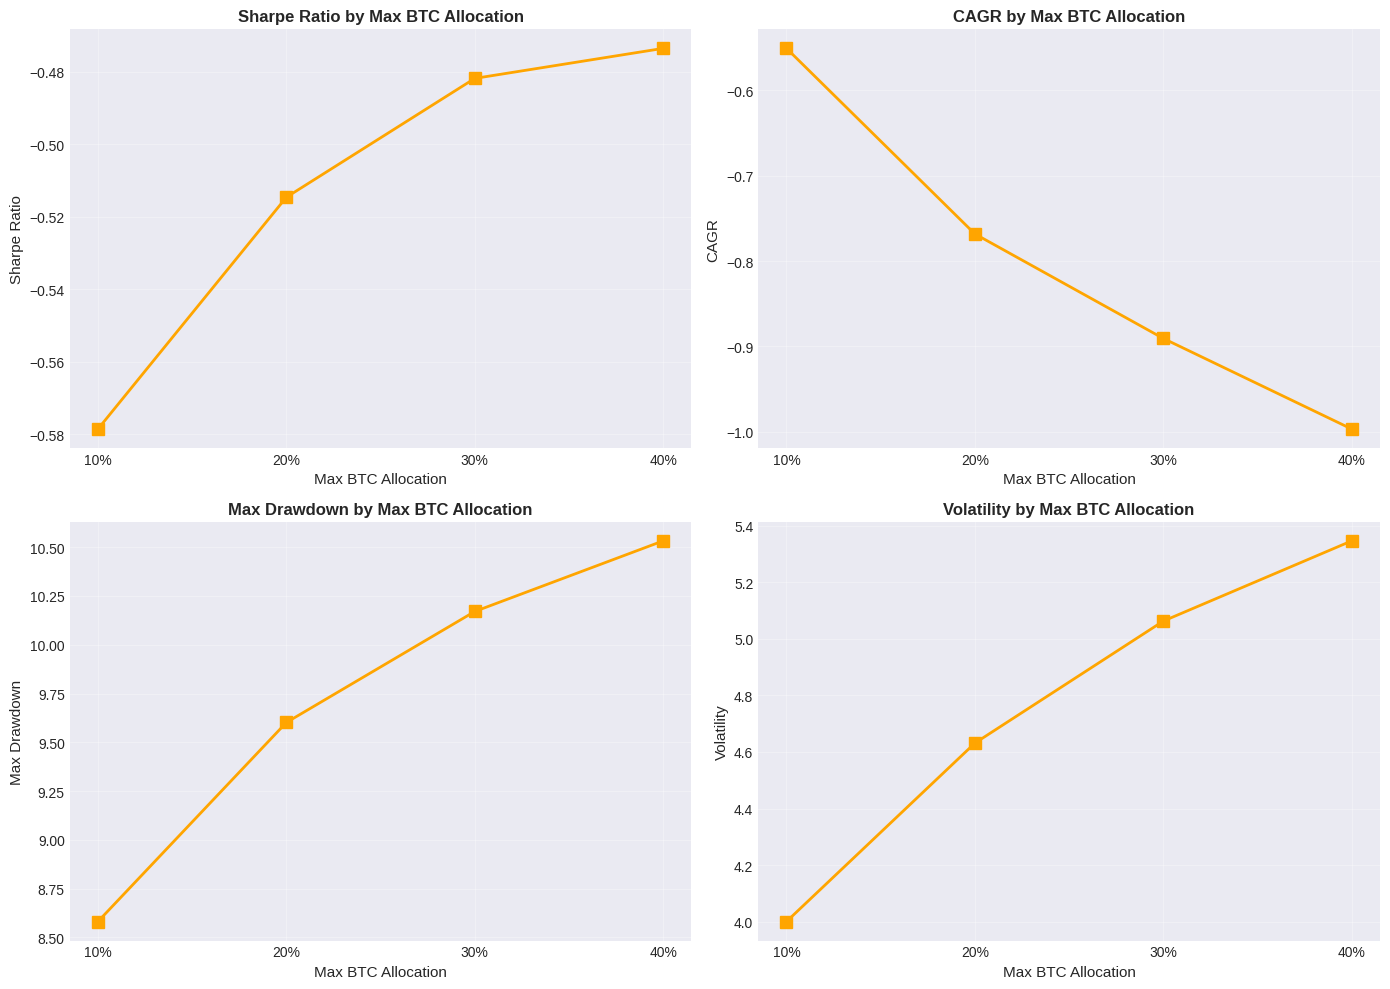

In [8]:
# Visualize Bitcoin allocation impact
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['Sharpe Ratio', 'CAGR', 'Max Drawdown', 'Volatility']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    values = btc_df[metric]
    if metric == 'CAGR' or metric == 'Max Drawdown' or metric == 'Volatility':
        values = values * 100
    
    ax.plot(range(len(values)), values, marker='s', linewidth=2, markersize=8, color='orange')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(btc_df.index)
    ax.set_xlabel('Max BTC Allocation', fontsize=11)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} by Max BTC Allocation', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Model Hyperparameter Sensitivity

In [9]:
# Test different max_depth values
max_depths = config['sensitivity']['max_depths']

print(f"Testing max_depth values: {max_depths}")
print(f"This will take a few minutes...\n")

depth_results = {}

for depth in max_depths:
    print(f"Testing max_depth: {depth}")
    
    # Modify config
    config_modified = config.copy()
    config_modified['model']['parameters']['max_depth'] = depth
    
    # Train model
    ml_model = PortfolioMLModel(config_modified)
    targets = ml_model.create_target_variables(returns, lookback=1)
    X_train, X_test, y_train, y_test = ml_model.prepare_train_test_data(
        features, targets, test_size=0.2
    )
    
    ml_model.train_all_models(X_train, y_train)
    
    # Evaluate
    eval_results = ml_model.evaluate_all_models(X_test, y_test)
    avg_r2 = eval_results['r2'].mean()
    
    # Generate allocations
    predicted_returns = ml_model.predict_returns(features)
    allocations = ml_model.calculate_optimal_allocations(predicted_returns)
    
    # Backtest
    backtester = PortfolioBacktester(config)
    results = backtester.backtest_strategy(allocations, returns, prices)
    metrics = backtester.calculate_all_metrics(results)
    
    depth_results[f'depth_{depth}'] = metrics
    
    print(f"  Avg R²: {avg_r2:.4f}")
    print(f"  Sharpe Ratio: {metrics['Sharpe Ratio']:.4f}")
    print()

print("Max depth analysis complete!")

Testing max_depth values: [3, 5, 7, 10]
This will take a few minutes...

Testing max_depth: 3

Training Models for All Assets
Training model for BTC-USD...
  Training MSE: 0.000728
  Training R²: 0.3335
Training model for GLD...
  Training MSE: 0.000034
  Training R²: 0.4015
Training model for SPY...
  Training MSE: 0.000048
  Training R²: 0.3599
Training model for TLT...
  Training MSE: 0.000021
  Training R²: 0.5813

Trained 4 models successfully!

Evaluating Models on Test Set

BTC-USD:
  RMSE: 0.024966
  MAE: 0.018433
  R²: -0.3490
  Directional Accuracy: 76.47%

GLD:
  RMSE: 0.009520
  MAE: 0.006221
  R²: -0.4659
  Directional Accuracy: 41.18%

SPY:
  RMSE: 0.011698
  MAE: 0.008033
  R²: -0.6179
  Directional Accuracy: 41.18%

TLT:
  RMSE: 0.008543
  MAE: 0.006341
  R²: -1.0094
  Directional Accuracy: 41.18%

Evaluation Complete!
  Avg R²: -0.6105
  Sharpe Ratio: -0.3512

Testing max_depth: 5

Training Models for All Assets
Training model for BTC-USD...
  Training MSE: 0.000614
  

In [10]:
# Convert to DataFrame
depth_df = pd.DataFrame(depth_results).T

print("Max Depth Sensitivity Results:")
display(depth_df[['Sharpe Ratio', 'Sortino Ratio', 'CAGR', 'Max Drawdown', 'Volatility']])

Max Depth Sensitivity Results:


,Sharpe Ratio,Sortino Ratio,CAGR,Max Drawdown,Volatility
depth_3,-0.3512,-0.5257,-0.0078,0.1228,0.0565
depth_5,-0.4735,-0.6325,-0.0100,0.1053,0.0535
depth_7,-0.5148,-0.6571,-0.0138,0.1235,0.0563
depth_10,-0.5135,-0.6547,-0.0136,0.1236,0.0562


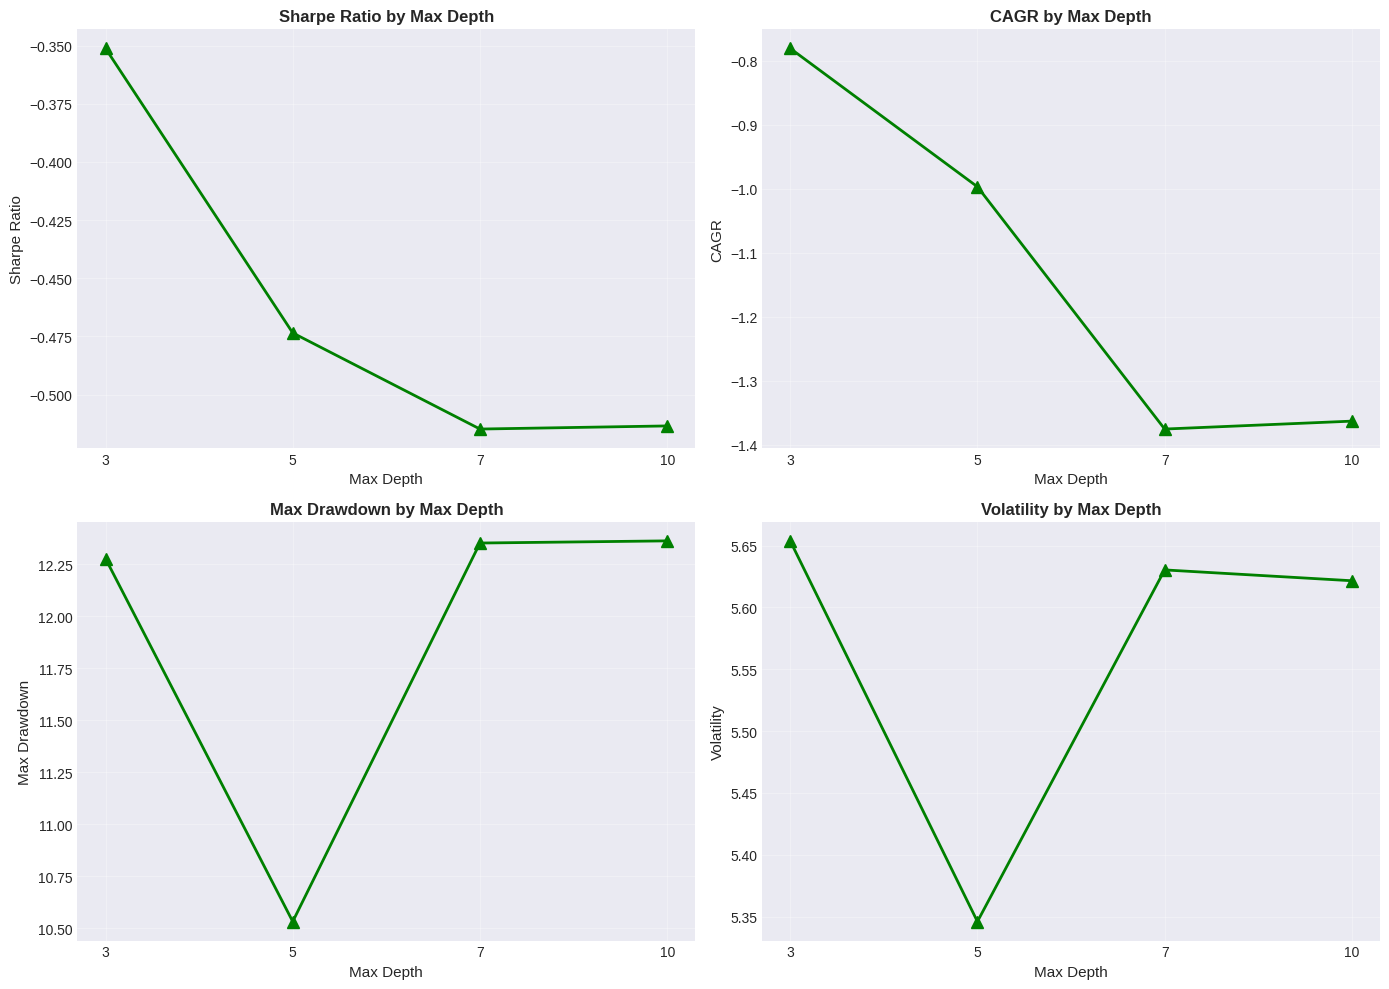

In [11]:
# Visualize max depth impact
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['Sharpe Ratio', 'CAGR', 'Max Drawdown', 'Volatility']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    values = depth_df[metric]
    if metric == 'CAGR' or metric == 'Max Drawdown' or metric == 'Volatility':
        values = values * 100
    
    ax.plot(range(len(values)), values, marker='^', linewidth=2, markersize=8, color='green')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels([f'{d}' for d in max_depths])
    ax.set_xlabel('Max Depth', fontsize=11)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} by Max Depth', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Combined Parameter Analysis

In [18]:
# Test different max_depth values
max_depths = config['sensitivity']['max_depths']

print(f"Testing max_depth values: {max_depths}")
print(f"This will take a few minutes...\n")

depth_results = {}

for depth in max_depths:
    print(f"Testing max_depth: {depth}")
    
    # Modify config
    config_modified = config.copy()
    config_modified['model']['parameters']['max_depth'] = depth
    
    # Train model
    ml_model = PortfolioMLModel(config_modified)
    targets = ml_model.create_target_variables(returns, lookback=1)
    X_train, X_test, y_train, y_test = ml_model.prepare_train_test_data(
        features, targets, test_size=0.2
    )
    
    ml_model.train_all_models(X_train, y_train)
    
    # Evaluate
    eval_results = ml_model.evaluate_all_models(X_test, y_test)
    avg_r2 = eval_results['r2'].mean()
    
    # Generate allocations
    predicted_returns = ml_model.predict_returns(features)
    allocations = ml_model.calculate_optimal_allocations(predicted_returns)
    
    # Backtest
    backtester = PortfolioBacktester(config)
    results = backtester.backtest_strategy(allocations, returns, prices)
    metrics = backtester.calculate_all_metrics(results)
    
    depth_results[f'depth_{depth}'] = metrics
    
    print(f"  Avg R²: {avg_r2:.4f}")
    print(f"  Sharpe Ratio: {metrics['Sharpe Ratio']:.4f}")
    print()

print("Max depth analysis complete!")


Testing max_depth values: [3, 5, 7, 10]
This will take a few minutes...

Testing max_depth: 3

Training Models for All Assets
Training model for BTC-USD...
  Training MSE: 0.000728
  Training R²: 0.3335
Training model for GLD...
  Training MSE: 0.000034
  Training R²: 0.4015
Training model for SPY...
  Training MSE: 0.000048
  Training R²: 0.3599
Training model for TLT...
  Training MSE: 0.000021
  Training R²: 0.5813

Trained 4 models successfully!

Evaluating Models on Test Set

BTC-USD:
  RMSE: 0.024966
  MAE: 0.018433
  R²: -0.3490
  Directional Accuracy: 76.47%

GLD:
  RMSE: 0.009520
  MAE: 0.006221
  R²: -0.4659
  Directional Accuracy: 41.18%

SPY:
  RMSE: 0.011698
  MAE: 0.008033
  R²: -0.6179
  Directional Accuracy: 41.18%

TLT:
  RMSE: 0.008543
  MAE: 0.006341
  R²: -1.0094
  Directional Accuracy: 41.18%

Evaluation Complete!
  Avg R²: -0.6105
  Sharpe Ratio: -0.3667

Testing max_depth: 5

Training Models for All Assets
Training model for BTC-USD...
  Training MSE: 0.000614
  

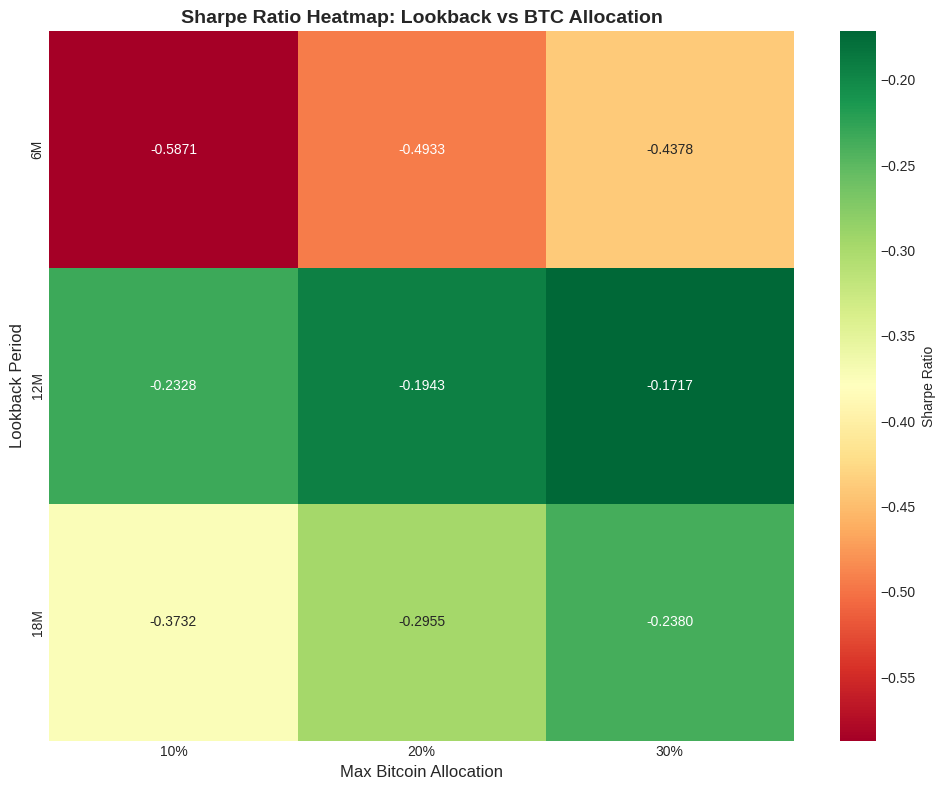


Optimal combination:
  Lookback: 12 months
  Max BTC Allocation: 30%
  Sharpe Ratio: -0.1717


In [19]:
# Create heatmap for lookback vs BTC allocation
if 'combined_results' not in locals() or 'lookback_test' not in locals() or 'btc_test' not in locals():
    print("Please run the previous cell that computes combined_results, lookback_test, and btc_test before plotting the heatmap.")
else:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(combined_results, 
                annot=True, 
                fmt='.4f', 
                cmap='RdYlGn',
                xticklabels=[f'{b*100:.0f}%' for b in btc_test],
                yticklabels=[f'{l}M' for l in lookback_test],
                ax=ax,
                cbar_kws={'label': 'Sharpe Ratio'})
    ax.set_xlabel('Max Bitcoin Allocation', fontsize=12)
    ax.set_ylabel('Lookback Period', fontsize=12)
    ax.set_title('Sharpe Ratio Heatmap: Lookback vs BTC Allocation', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    # Find optimal combination
    max_idx = np.unravel_index(combined_results.argmax(), combined_results.shape)
    optimal_lookback = lookback_test[max_idx[0]]
    optimal_btc = btc_test[max_idx[1]]
    optimal_sharpe = combined_results[max_idx]
    print(f"\nOptimal combination:")
    print(f"  Lookback: {optimal_lookback} months")
    print(f"  Max BTC Allocation: {optimal_btc*100:.0f}%")
    print(f"  Sharpe Ratio: {optimal_sharpe:.4f}")

## 6. Robustness Summary

In [20]:
# Create heatmap for lookback vs BTC allocation
print("Creating combined parameter analysis...")

# Smaller grid for computational efficiency
lookback_test = [6, 12, 18]
btc_test = [0.10, 0.20, 0.30]

combined_results = np.zeros((len(lookback_test), len(btc_test)))

for i, lookback in enumerate(lookback_test):
    for j, max_btc in enumerate(btc_test):
        print(f"Testing: Lookback={lookback}M, Max BTC={max_btc*100:.0f}%")
        
        # Modify config
        config_temp = config.copy()
        for asset in config_temp['assets']['alternative']:
            if 'BTC' in asset['ticker']:
                asset['max_allocation'] = max_btc
        
        # Prepare features
        feature_eng = FeatureEngineer(config_temp)
        features_raw = feature_eng.engineer_all_features(indicators)
        features = feature_eng.prepare_features_for_training(features_raw)
        
        # Train and backtest
        ml_model = PortfolioMLModel(config_temp)
        targets = ml_model.create_target_variables(returns, lookback=1)
        
        test_size = max(0.2, (lookback + 12) / len(features))
        X_train, X_test, y_train, y_test = ml_model.prepare_train_test_data(
            features, targets, test_size=test_size
        )
        
        ml_model.train_all_models(X_train, y_train)
        predicted_returns = ml_model.predict_returns(features)
        allocations = ml_model.calculate_optimal_allocations(predicted_returns)
        
        backtester = PortfolioBacktester(config_temp)
        results = backtester.backtest_strategy(allocations, returns, prices)
        metrics = backtester.calculate_all_metrics(results)
        
        combined_results[i, j] = metrics['Sharpe Ratio']

print("\nCombined analysis complete!")


Creating combined parameter analysis...
Testing: Lookback=6M, Max BTC=10%

Training Models for All Assets
Training model for BTC-USD...
  Training MSE: 0.000621
  Training R²: 0.4402
Training model for GLD...
  Training MSE: 0.000022
  Training R²: 0.6162
Training model for SPY...
  Training MSE: 0.000029
  Training R²: 0.6149
Training model for TLT...
  Training MSE: 0.000016
  Training R²: 0.6870

Trained 4 models successfully!
Testing: Lookback=6M, Max BTC=20%

Training Models for All Assets
Training model for BTC-USD...
  Training MSE: 0.000621
  Training R²: 0.4402
Training model for GLD...
  Training MSE: 0.000022
  Training R²: 0.6162
Training model for SPY...
  Training MSE: 0.000029
  Training R²: 0.6149
Training model for TLT...
  Training MSE: 0.000016
  Training R²: 0.6870

Trained 4 models successfully!
Testing: Lookback=6M, Max BTC=30%

Training Models for All Assets
Training model for BTC-USD...
  Training MSE: 0.000621
  Training R²: 0.4402
Training model for GLD...
  T